# <img src="../Images/image.png" alt="Business Description Clustering using NLP" width="400">


# Business Description Clustering with SBERT

This project builds a natural language processing pipeline to cluster **S&P 500 companies** based on the semantic content of their business descriptions using **SBERT embeddings** and **hierarchical clustering**.

The primary objective is to uncover functionally similar companies by analyzing their descriptions and grouping them according to operational or funtional characteristics.

## Objectives

- Extract and preprocess business descriptions for S&P 500 companies
- Generate text embeddings using SBERT
- Apply dimensionality reduction techniques to streamline embeddings
- Perform hierarchical clustering to identify natural groupings and sectoral patterns

## Table of Contents

1. [Setup](#1-setup)  
2. [Data Collection](#2-data-collection)
3. [Text Preprocessing](#3-text-preprocessing)
4. [SBERT Embedding Generation](#4-sbert-embedding-generation)
5. [Dimension Reduction](#5-dimension-reduction)
6. [Hierarchical Clustering](#6-hierarchical-clustering)    
7. [Conclusion](#7-conclusion)


## 1. Setup 

In this section, I import all necessary libraries for data collection, processing, and analysis. I use `yfinance` for gathering company data, `nltk` and `spacy` for text processing, `sentence_transformers` for generating embeddings, and various scikit-learn components for dimensionality reduction and clustering.

The SBERT model "multi-qa-MiniLM-L6-cos-v1" is selected as it is lite.

In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import re
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

# NLP tools
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
import spacy

# Embedding and clustering tools
from sentence_transformers import SentenceTransformer
from umap import UMAP
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Initialize the SBERT model 
model = SentenceTransformer("multi-qa-MiniLM-L6-cos-v1")


## 2. Data Collection

This section focuses on gathering data for our analysis. We use two main sources:

1. **Wikipedia**: To extract the current list of S&P 500 companies and their industry classifications
2. **Yahoo Finance API (via yfinance)**: To obtain detailed business descriptions for each company

The S&P 500 list includes company tickers, names, sectors, and sub-industry classifications according to the Global Industry Classification Standard (GICS). This structured data will help us validate our clustering results later.

After retrieval, I perform basic data cleaning on the ticker symbols to ensure compatibility with the Yahoo Finance API format (replacing periods with dashes).

In [ ]:
# Extract S&P 500 tickers from Wikipedia
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
sp500_table = pd.read_html(url)[0]  # The first table is the S&P 500 list
tickers = sp500_table['Symbol'].tolist()

# Replace periods with dashes (e.g., BRK.B -> BRK-B) as yfinance requires this format
tickers = [ticker.replace('.', '-') for ticker in tickers]

# Use yfinance to extract business descriptions for each ticker
bd_data = []
errors = []
for ticker in tickers:
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        description = info.get('longBusinessSummary', '') # Retrieve the long business summary
        bd_data.append({'Symbol': ticker, 'long_bd': description})
    except Exception as e:
        errors.append({'Symbol': ticker, 'error': str(e)})

# Add business description data to S&P 500 table
df = pd.merge(sp500_table, pd.DataFrame(bd_data), on='Symbol', how='left')

# Print number of errors
print(f"Number of errors: {len(errors)}")

Number of errors: 75


Note: The Yahoo Finance API has rate limits that may cause errors when retrieving company data.

In [6]:
# Clean up column names for consistency
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace(" ", "_")
df.columns = df.columns.str.replace(".", "_")
df.columns = df.columns.str.replace("-", "_")

In [7]:
# Focus only on relevant columns for our analysis
df = df.drop(columns=['headquarters_location', 'date_added', 'cik', 'founded'])

# Rename columns for clarity and consistency
df.rename(columns={'symbol': 'ticker', 'security': 'company', 'gics_sector': 'industry', 'gics_sub_industry': 'sub_industry', 'long_bd': 'long_bd'}, inplace=True)

In [8]:
# Display first five rows of the dataset
df.head()

,ticker,company,industry,sub_industry,long_bd
0,MMM,3M,Industrials,Industrial Conglomerates,3M Company provides diversified technology ser...
1,AOS,A. O. Smith,Industrials,Building Products,A. O. Smith Corporation manufactures and marke...
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"Abbott Laboratories, together with its subsidi..."
3,ABBV,AbbVie,Health Care,Biotechnology,"AbbVie Inc., a research-based biopharmaceutica..."
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,Accenture plc provides strategy and consulting...


In [9]:
# Display basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503 entries, 0 to 502
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ticker        503 non-null    object
 1   company       503 non-null    object
 2   industry      503 non-null    object
 3   sub_industry  503 non-null    object
 4   long_bd       426 non-null    object
dtypes: object(5)
memory usage: 19.8+ KB


In [10]:
# Number of Industries and Sub-Industries in the S&P 500
print(f"Number of Industries: {len(df['industry'].value_counts())}")
print(f"Number of Sub-Industries: {len(df['sub_industry'].value_counts())}")


Number of Industries: 11
Number of Sub-Industries: 129


## 3. Text Preprocessing

SBERT works well with raw text, so only light preprocessing is needed to clean and focus the business descriptions. The goal is to remove noise and keep only the most relevant content. Here's what we do:

- **Remove any rows with missing descriptions** to avoid issues during embedding.
- **Strip out HTML tags** like `<br>` or `<div>` to keep only readable text.
- **Clean up extra spaces, tabs, or line breaks** and trim the text for consistency.
- **Keep only the first two sentences of the business descriptions.**

This focused approach helps to capture the core business activities while reducing noise from promotional or peripheral content that often appears later in business descriptions.

In [11]:
# Text preprocessing function
def preprocess_text(text):
    """
    Cleans the input text and retains only the first two sentences describing a business activity.
    """
    if pd.isna(text):
        return None
    text = re.sub(r'<[^>]+>', ' ', text)  # Remove HTML tags
    text = re.sub(r'\s+', ' ', text)  # Normalize whitespace
    sentences = sent_tokenize(text)
    
    if len(sentences) >= 2:
        return sentences[0] + " " + sentences[1]  
    return None

# Apply preprocessing to the DataFrame
df['clean_bd'] = df['long_bd'].apply(preprocess_text)
df = df.dropna(subset=['clean_bd'])

print("Preprocessing complete. Example cleaned description:")
print(df['clean_bd'].iloc[0])



Preprocessing complete. Example cleaned description:
3M Company provides diversified technology services in the Americas, the Asia Pacific, Europe, the Middle East, Africa, and internationally. It operates through three segments: Safety and Industrial, Transportation and Electronics, and Consumer.


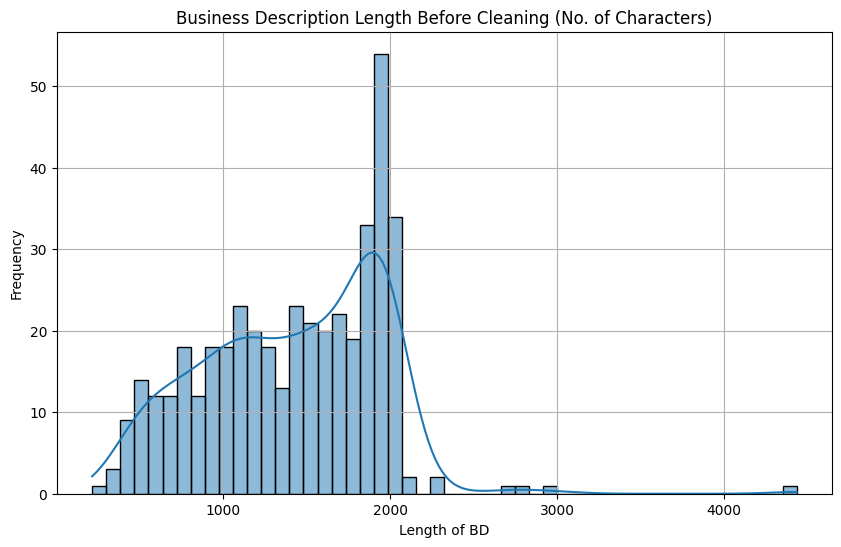

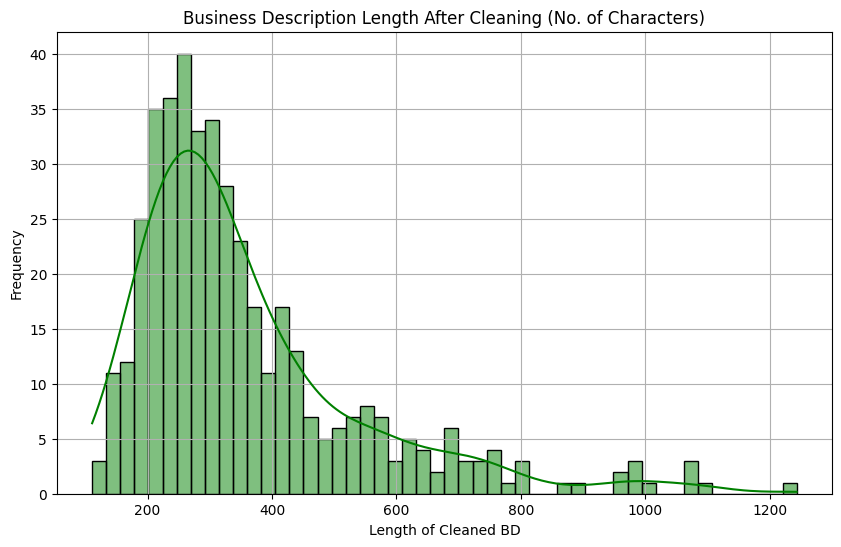

In [12]:
# Visualize business description length before cleaning
long_bd_length = df['long_bd'].dropna().apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(long_bd_length, bins=50, kde=True)
plt.title('Business Description Length Before Cleaning (No. of Characters)')
plt.xlabel('Length of BD')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Visualize business description length after cleaning
clean_bd_length = df['clean_bd'].dropna().apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(clean_bd_length, bins=50, kde=True, color='green')
plt.title('Business Description Length After Cleaning (No. of Characters)')
plt.xlabel('Length of Cleaned BD')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


**Effect of Text Preprocessing**: By focusing on just the first two sentences, we significantly reduce the length of business descriptions while retaining their core essence. This approach helps filter out most non relevant language and focus on the fundamental operational descriptions of each company. The histogram shows how our preprocessing dramatically standardizes the text length, making it more suitable for embedding generation.

## 4. SBERT Embedding Generation  

In this section, I convert the processed business descriptions into numerical vectors (embeddings) using the Sentence-BERT (SBERT) model. SBERT is a modification of the BERT architecture optimized for generating semantically meaningful sentence embeddings.

The model "multi-qa-MiniLM-L6-cos-v1" was chosen because it:
- Is optimized for semantic similarity tasks
- Has a good balance between model size and performance
- Works well with short to medium-length texts (like our business descriptions)

These embeddings capture the semantic meaning of the business descriptions, enabling us to measure similarity between companies based on the content of their descriptions rather than just keyword matching.

In [13]:
# Generate embeddings for all business descriptions
embeddings = model.encode(df['clean_bd'].tolist(), show_progress_bar=True)

# Convert embeddings to numpy array for easier manipulation
embeddings = np.array(embeddings)

# Print embedding shape to verify dimensions
print(f"Embedding shape: {embeddings.shape}")


Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Embedding shape: (425, 384)


## 5. Dimension Reduction

The raw SBERT embeddings are high-dimensional (384 dimensions), which can lead to the "curse of dimensionality" problem when clustering. To address this, we apply dimension reduction techniques in two stages:

1. **PCA (Principal Component Analysis)**: First, we use PCA to check the loss in variance when reducing the dimensionality. This helps us understand how many dimensions we actually need.

2. **UMAP (Uniform Manifold Approximation and Projection)**: Then, we apply UMAP to reduce dimensions while preserving both the local and global structure of the data. UMAP is particularly good at capturing non-linear relationships in the data.

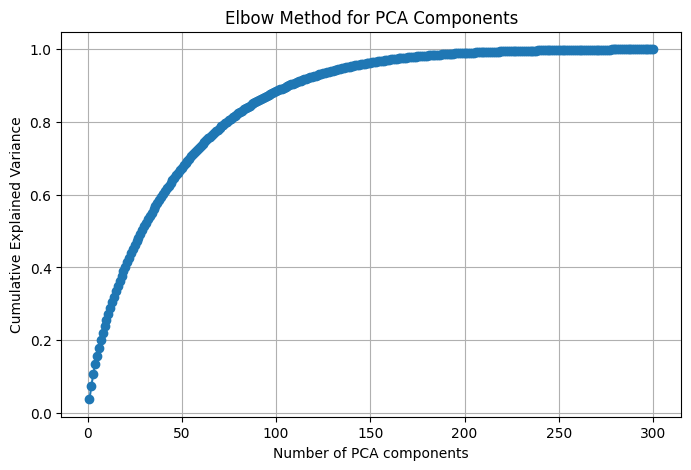

In [16]:
# Run PCA first to understand variance distribution
pca = PCA(n_components=300)
pca_result = pca.fit_transform(embeddings)

# Plot cumulative explained variance to help determine optimal number of components
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8,5))
plt.plot(range(1, 301), explained_variance, marker='o')
plt.xlabel('Number of PCA components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Elbow Method for PCA Components')
plt.grid(True)
plt.show()


In [23]:
# Calculate and print cumulative variance at n = 100
embedding_size = 100
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print(f"Cumulative explained variance at 100 components: {cumulative_variance[embedding_size]:.4f}")

Cumulative explained variance at 100 components: 0.8865


In [24]:
# Apply UMAP for dimension reduction 
umap_reducer = UMAP(
    n_components=embedding_size,
    random_state=42,
    n_neighbors=15,  
    min_dist=0.1     
)

# Fit and transform the embeddings
reduced_embeddings = umap_reducer.fit_transform(embeddings)
print(f"Reduced embedding shape: {reduced_embeddings.shape}")

# Create a DataFrame with embeddings for further analysis
embeddings_df = pd.DataFrame(
    reduced_embeddings,
    columns=[f'embedding_{i}' for i in range(reduced_embeddings.shape[1])]
)

# Join embeddings with company information
df_with_embeddings = df.reset_index(drop=True).join(embeddings_df).sort_values(by=['industry', 'sub_industry'])


Reduced embedding shape: (425, 100)


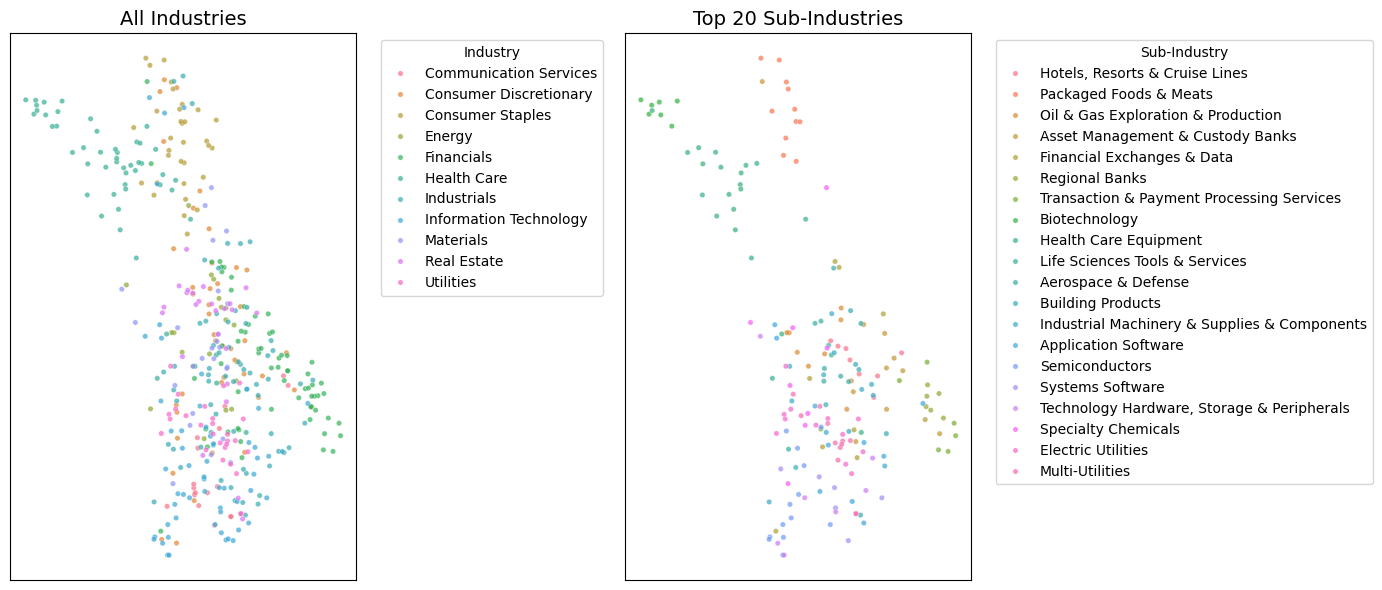

In [25]:
# Helper function for embedding plots
def embedding_figure(ax, title: str = 'Title'):
    ax.set_title(title, fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    
# Create visualizations to check if embeddings preserve industry structure
f, axs = plt.subplots(1, 2, figsize=(14, 6))
axs = axs.flatten()

# Plot by industry (first two dimensions only)
sns.scatterplot(
    data=df_with_embeddings,
    x='embedding_0', y='embedding_1',
    hue='industry',
    s=15, alpha=0.7,
    ax=axs[0],
    legend='brief'
)
axs[0].legend(title='Industry', bbox_to_anchor=(1.05, 1), loc='upper left')
embedding_figure(axs[0], 'All Industries')

# Get top 20 sub-industries (for better visualization)
top_20_subindustries = df_with_embeddings['sub_industry'].value_counts().nlargest(20).index.tolist()
top_20_subindustry_data = df_with_embeddings[df_with_embeddings['sub_industry'].isin(top_20_subindustries)]

# Plot by sub-industry (top 20 only)
sns.scatterplot(
    data=top_20_subindustry_data,
    x='embedding_0', y='embedding_1',
    hue='sub_industry',
    s=15, alpha=0.7,
    ax=axs[1],
    legend='brief'
)
axs[1].legend(title='Sub-Industry', bbox_to_anchor=(1.05, 1), loc='upper left')
embedding_figure(axs[1], 'Top 20 Sub-Industries')

plt.tight_layout()
plt.show()


The plot shows a 2D view of 100-dimensional embeddings. While some industry clusters are visible, there is noticeable overlap—likely due to the dimensionality reduction. Sub-industries are harder to separate, so the 2D plot may not fully reflect the quality of the original high-dimensional data.

## 6. Hierarchical Clustering

Hierarchical clustering is an ideal approach for this dataset because:

1. It creates a hierarchical structure that can reveal relationships at different levels of granularity
2. It produces a dendrogram visualization that makes it easy to interpret relationships

I use Ward's linkage method, which minimizes the variance within each cluster. This tends to create more balanced, compact clusters compared to other linkage methods.

The process involves:
1. Standardizing the embedding features to give equal weight to all dimensions
2. Computing a linkage matrix that defines the cluster hierarchy
3. Creating a dendrogram to visualize the clustering structure
4. Cutting the dendrogram at an appropriate level to create our final clusters

In [26]:
# Standardize embeddings to give equal weight to all dimensions
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(reduced_embeddings)

# Compute linkage matrix using Ward's method (minimizes variance within clusters)
linkage_matrix = linkage(embeddings_scaled, method='ward')


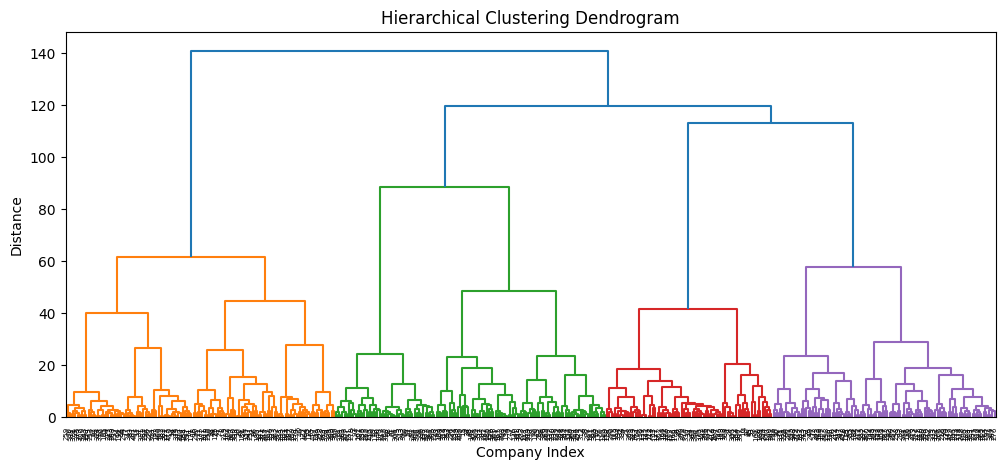

In [27]:
# Plot dendrogram to visualize hierarchical structure
plt.figure(figsize=(12, 5))
dendrogram(linkage_matrix, truncate_mode='level') 
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Company Index')
plt.ylabel('Distance')
plt.show()

In [28]:
# Create clusters by cutting the dendrogram to match the number of GICS sectors (11)
cluster_labels = fcluster(linkage_matrix, t=11, criterion='maxclust')
df_with_embeddings['cluster'] = cluster_labels

Number of companies in each cluster:
cluster
1     27
2     31
3     39
4     26
5     46
6     38
7     40
8     53
9     23
10    40
11    62
Name: count, dtype: int64


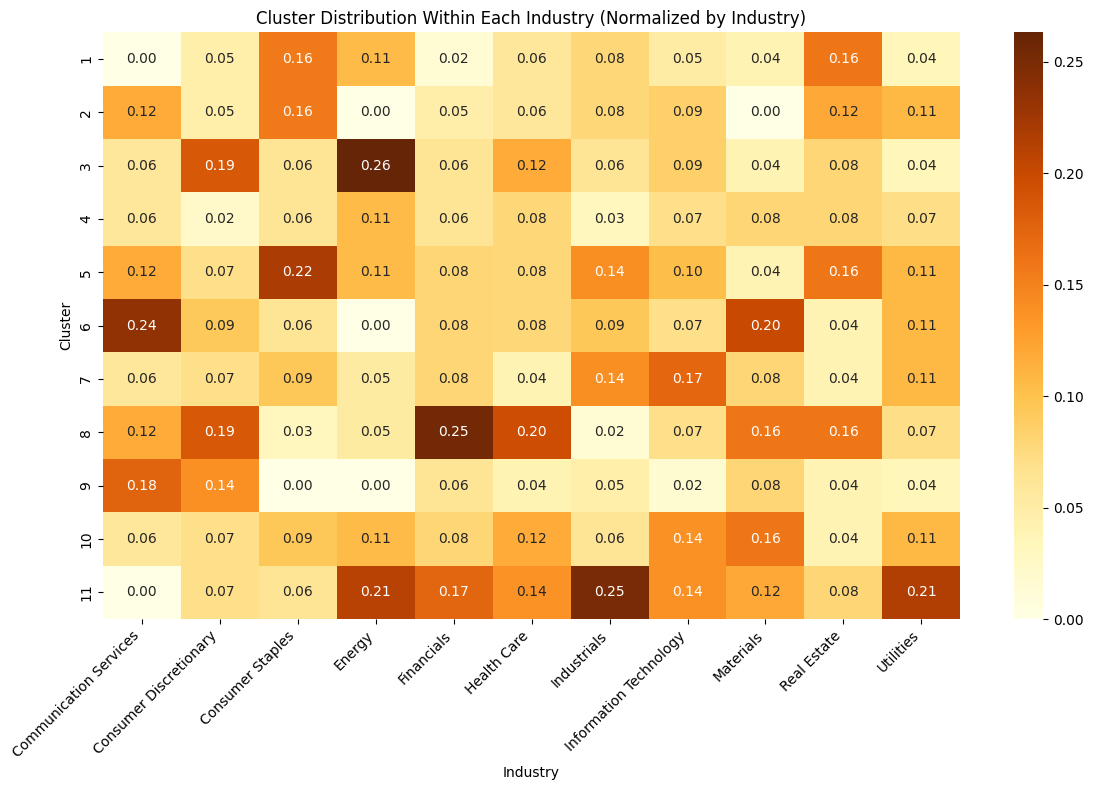

In [29]:
# Examine cluster size distribution
cluster_counts = df_with_embeddings['cluster'].value_counts().sort_index()
print("Number of companies in each cluster:")
print(cluster_counts)

# Industry distribution within each cluster (cross-tabulation)
industry_cluster = pd.crosstab(df_with_embeddings['cluster'], df_with_embeddings['industry'])

# Normalize by industry (columns) to see distribution of each industry across clusters
industry_cluster_norm = industry_cluster.div(industry_cluster.sum(axis=0), axis=1)

# Plot heatmap of industry distribution across clusters
plt.figure(figsize=(12, 8))
sns.heatmap(industry_cluster_norm, annot=True, fmt=".2f", cmap="YlOrBr")
plt.title("Cluster Distribution Within Each Industry (Normalized by Industry)")
plt.xlabel("Industry")
plt.ylabel("Cluster")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


The clustering shows potential, especially in well-defined sectors like Financials, Engergy, and Industrials. But across many industries, the signal is diluted — clustering boundaries are fuzzy, and there's too much overlap.

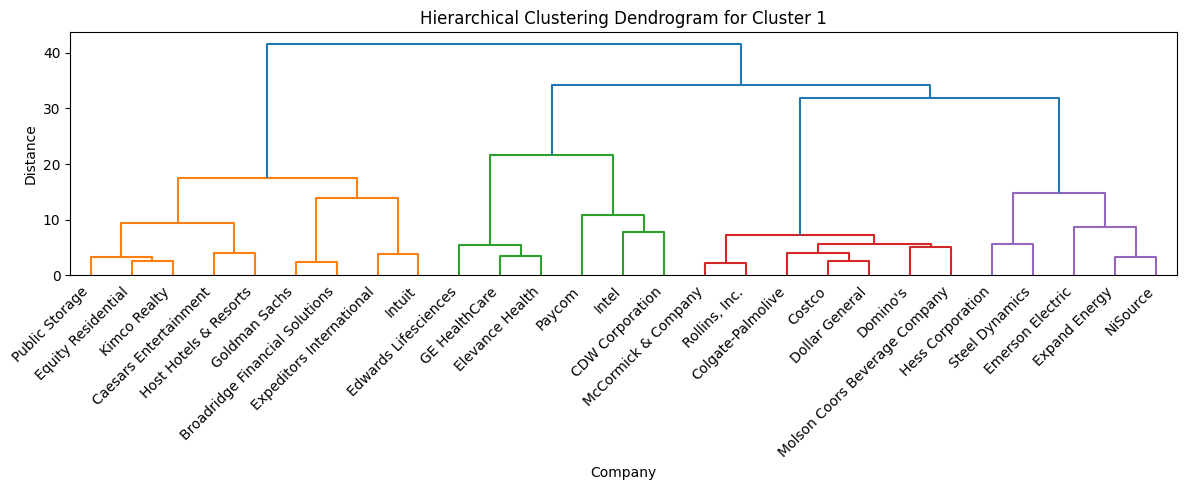

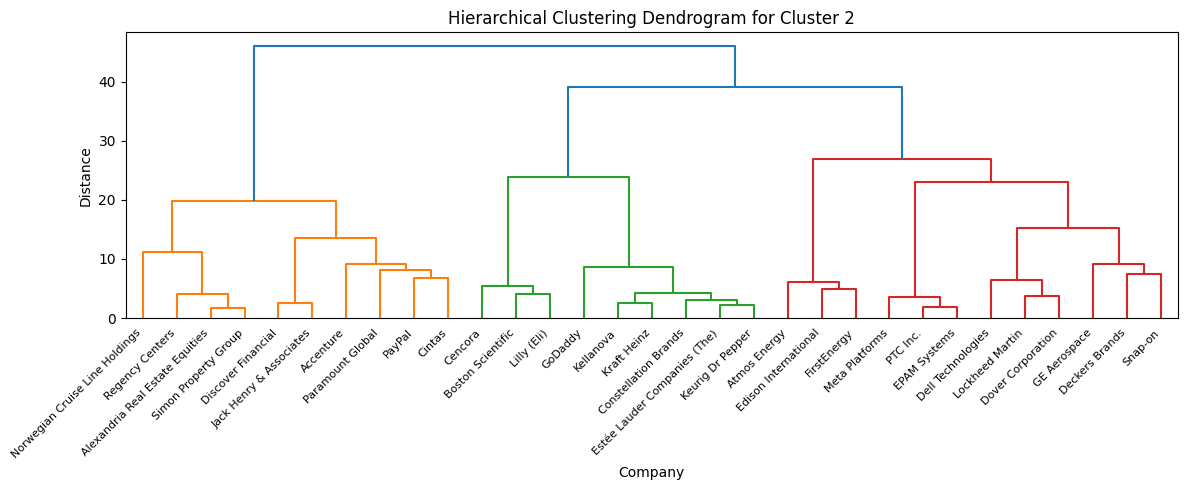

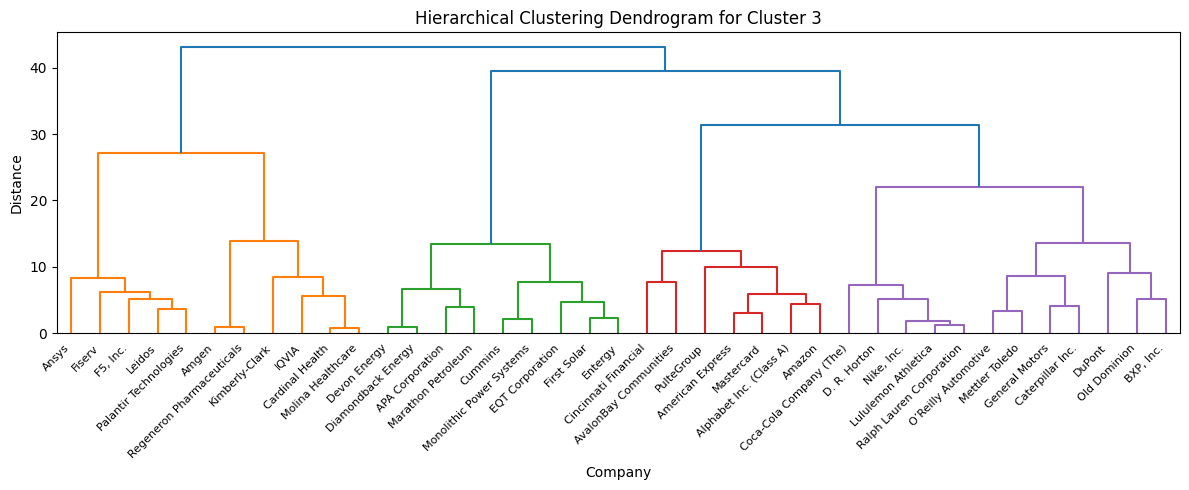

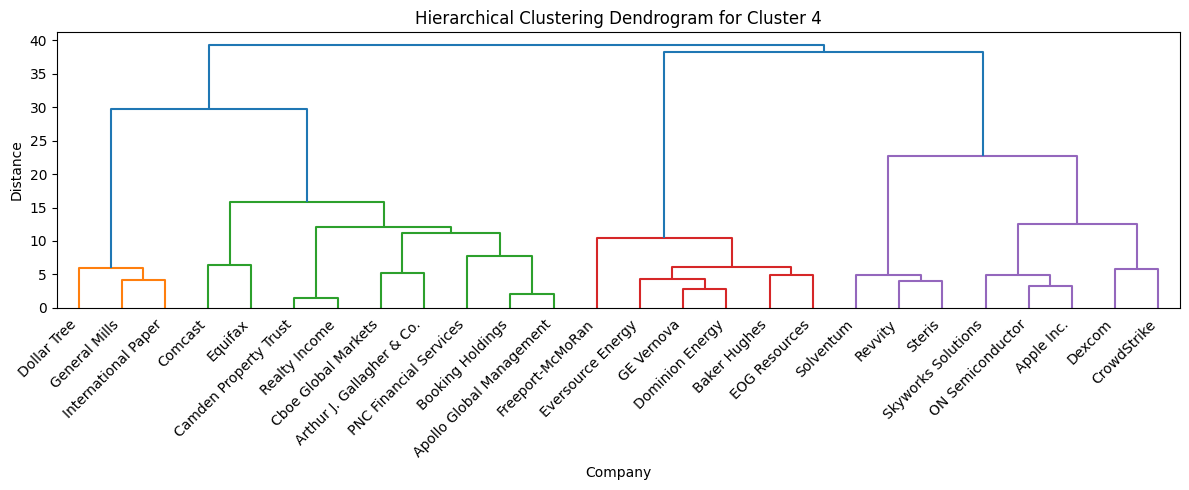

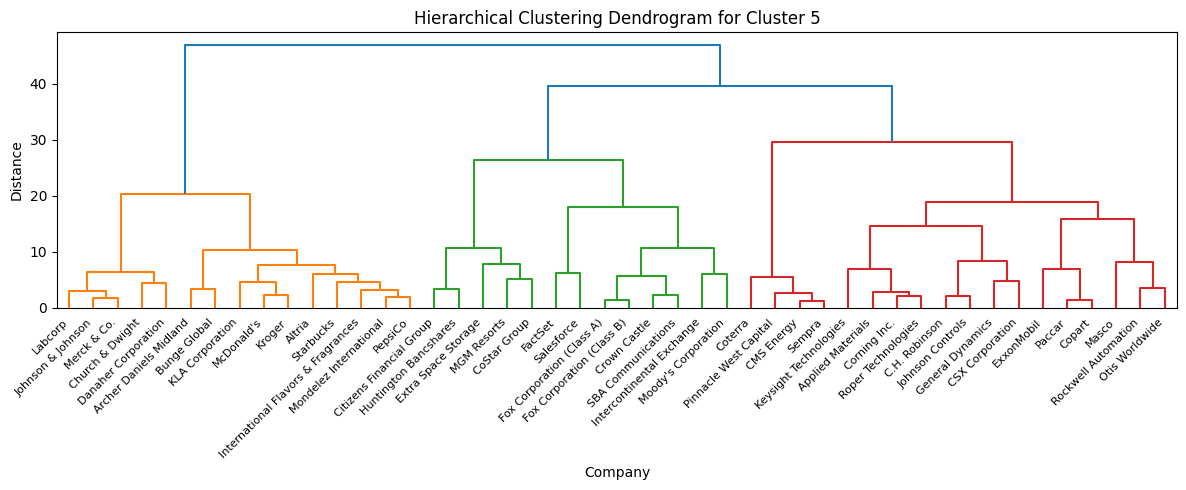

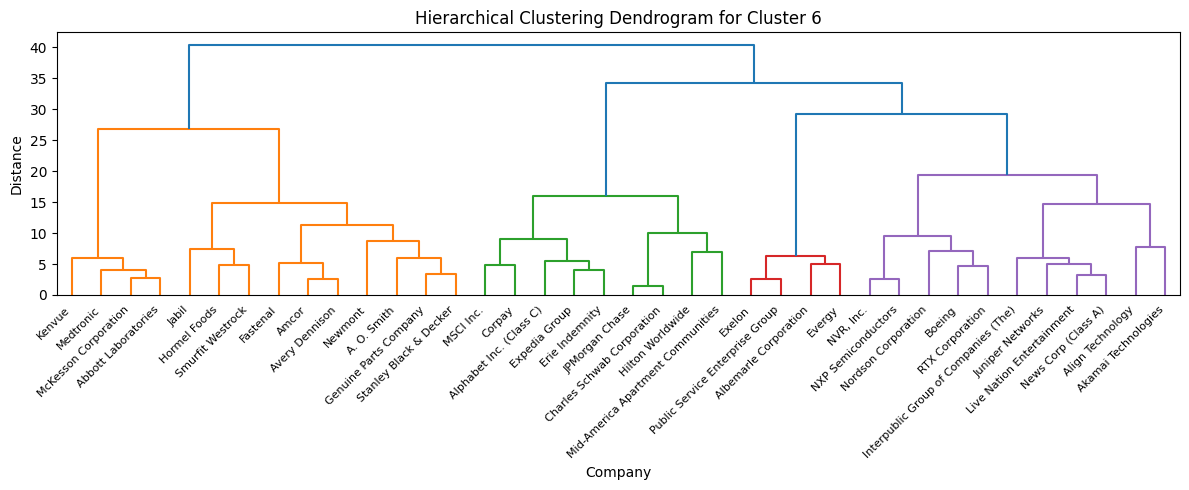

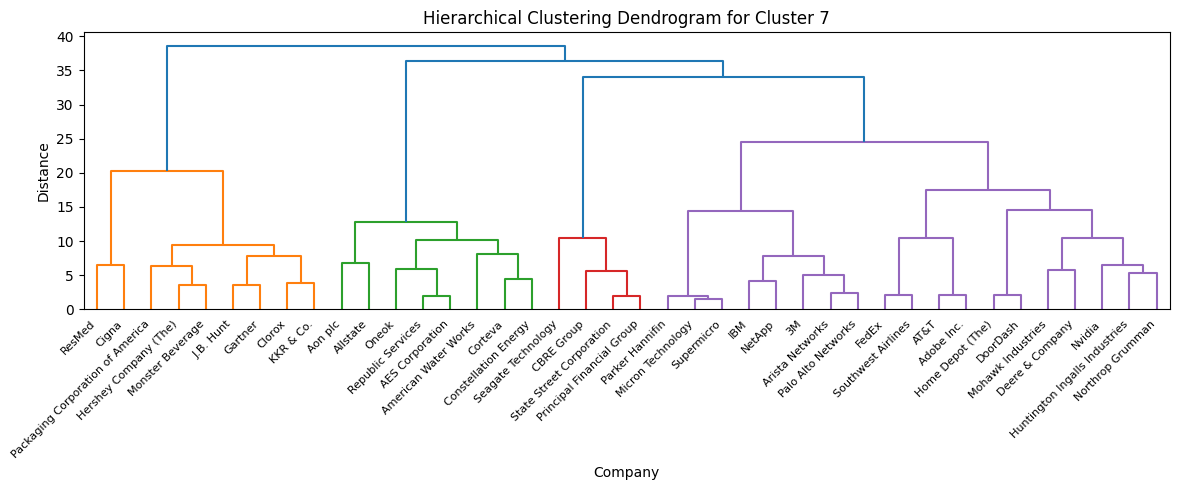

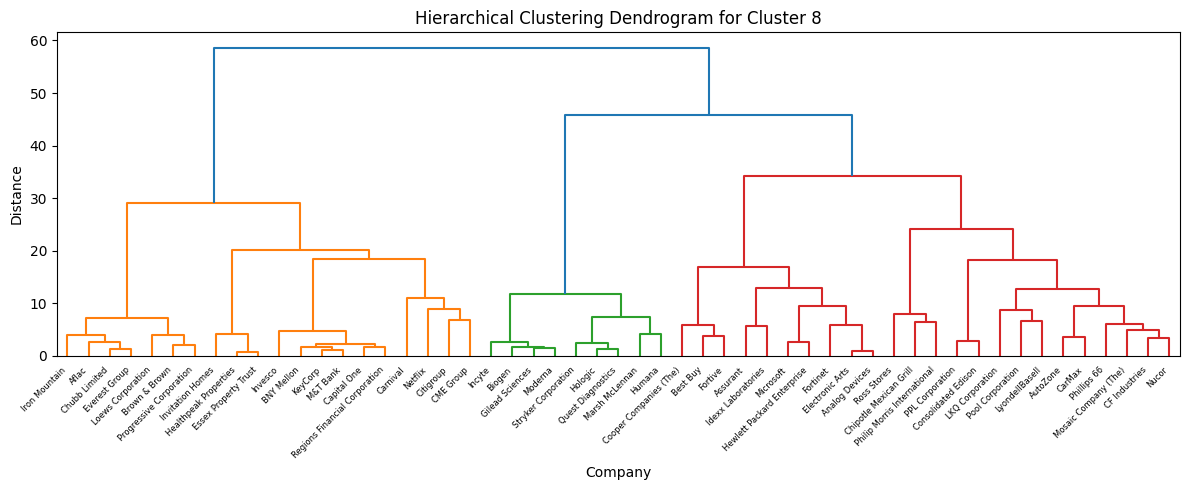

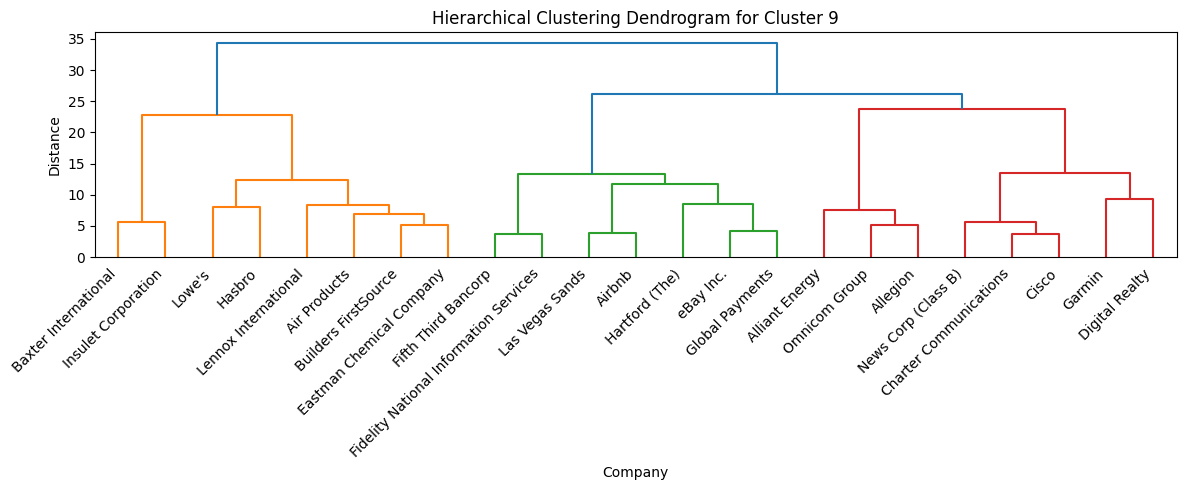

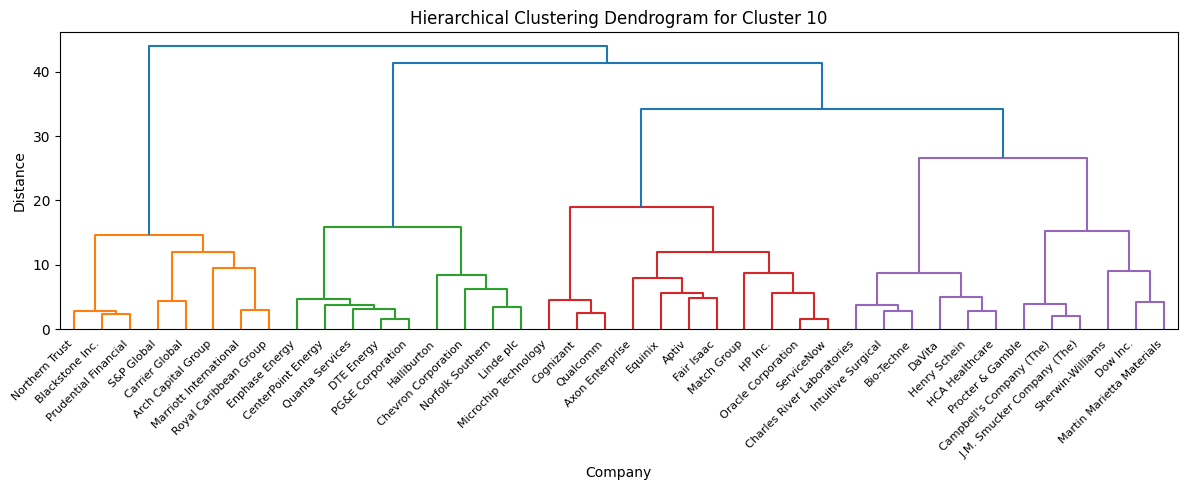

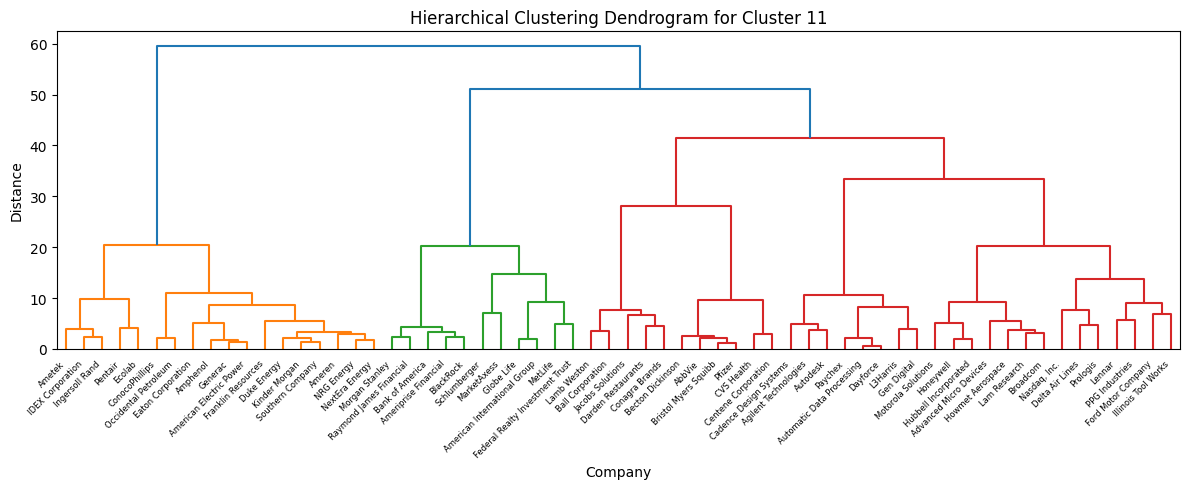

In [30]:
# Plot dendrograms for individual clusters to examine their internal structure
for cluster in sorted(df_with_embeddings['cluster'].unique()):
    # Filter data for the current cluster
    cluster_data = df_with_embeddings[df_with_embeddings['cluster'] == cluster]
    
    # Skip very large clusters for clarity
    if len(cluster_data) > 100:
        print(f"Cluster {cluster} has {len(cluster_data)} companies, skipping detailed dendrogram.")
        continue
        
    # Get indices of companies in this cluster
    cluster_indices = cluster_data.index
    
    # Extract embeddings for this cluster
    cluster_embeddings = embeddings_scaled[cluster_indices]
    
    # Compute linkage matrix for this cluster
    if len(cluster_embeddings) > 1:  # Need at least 2 points for linkage
        cluster_linkage = linkage(cluster_embeddings, method='ward')
        
        # Get company names for this cluster
        company_names = cluster_data['company'].values
        
        # Plot dendrogram for this cluster
        plt.figure(figsize=(12, 5))
        dendrogram(cluster_linkage, labels=company_names, leaf_rotation=90)
        plt.title(f'Hierarchical Clustering Dendrogram for Cluster {cluster}')
        plt.xlabel('Company')
        plt.ylabel('Distance')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Cluster {cluster} has only {len(cluster_embeddings)} company, skipping dendrogram.")

## 7. Conclusion  

This project developed a clustering pipeline to group S&P 500 companies based on their business descriptions using SBERT embeddings and hierarchical clustering. While the method uncovered some meaningful patterns, the results also revealed limitations in distinguishing companies across diverse industries using textual data alone.  

### Key Findings  

- SBERT embeddings captured general semantic similarities in business descriptions, effectively grouping companies with clear operational focus.  
- The dimensionality reduction pipeline preserved enough structure for visual exploration, though some loss of cluster clarity was observed due to projection from 100 to 2 dimensions.  
- Hierarchical clustering uncovered a mix of coherent and loosely connected company groupings:  
  - Some clusters aligned well with known industry groupings.  
  - Others contained significant cross-industry mixing, reflecting generic language or overlapping business functions.  
- Companies within the same traditional sector often split across multiple clusters, while others aligned more closely with firms from different sectors—highlighting semantic but not always meaningful business overlap.  

### Realistic Performance Assessment  

**Strengths:** Clear cluster patterns for a few sectors; interpretable subgroupings within large clusters.  

**Limitations:** Several clusters were too broad or mixed, reflecting challenges in handling short, generic business descriptions. Dimensionality reduction and cluster assignment parameters (e.g., number of clusters) likely contributed to performance constraints.  

### Implementation Value  

Despite limitations, the project demonstrates how natural language processing can augment traditional classification systems. While not yet a replacement for GICS or NAICS codes, semantic clustering adds value by:  

- Offering a new lens for competitive analysis and peer identification  
- Supporting portfolio diversification based on business model similarity, not just sector  
- Highlighting opportunities for cross-industry comparisons in strategic planning  

Future work could explore model fine-tuning, domain-specific embedding training, or hybrid clustering approaches to improve precision and interpretability.  